In [1]:
import pandas as pd
import numpy as np
import os
from IPython.display import display
pd.set_option('display.max_columns', None)
import geopandas as gpd
from shapely import Point, Polygon, MultiPolygon
import contextily as ctx

import mapclassify
from matplotlib import pyplot as plt
import warnings
warnings.filterwarnings('ignore')
from scipy.spatial import Voronoi
import osmnx as ox
ox.config(log_console=True, use_cache=True)
import pyproj
import math
from tqdm.notebook import tqdm
tqdm.pandas()
from collections import defaultdict
from sklearn.neighbors import BallTree

In [2]:
def calc_voronoi(list_points, delta=100000):
    
    xmin, ymin, xmax, ymax = gpd.GeoSeries(list_points).total_bounds
    p_min = Point(xmin - delta, ymin - delta)
    p_max = Point(xmax + delta, ymax + delta)
    
    # create voronoi polygons
    num_points = round(len(list_points) ** 0.5) + 10
    rows = np.linspace(p_min.y, p_max.y, num_points)
    cols = np.linspace(p_min.x, p_max.x, num_points)
    
    list_xy_extended = np.concatenate([
        list(map(lambda p: (p.x, p.y), list_points)),
        [(p_min.x, y) for y in rows],
        [(p_max.x, y) for y in rows],
        [(x, p_min.y) for x in cols],
        [(x, p_max.y) for x in cols],
    ])
    
    vor = Voronoi(list_xy_extended)
    
    region_poly = {
        i: Polygon(vor.vertices[region])
        for i, region in enumerate(vor.regions)
        if -1 not in region and len(region) > 2
    }
    
    polygons = [
        region_poly[region_id] if region_id in region_poly else None
        for region_id in vor.point_region[:len(list_points)]
    ]
    
    return polygons

def calc_earth_radius(lon):
    B = math.radians(lon)
    r1 = 6378.137
    r2 = 6356.752
    a = math.pow(math.pow(r1, 2) * math.cos(B), 2)
    b = math.pow(math.pow(r2, 2) * math.sin(B), 2)
    c = math.pow(r1 * math.cos(B), 2)
    d = math.pow(r2 * math.sin(B), 2)
    R = math.sqrt((a+b) / (c+d)) * 1000
    return R

def calc_crs(point: Point):
    lon, lat = point.x, point.y
    radius = calc_earth_radius(lon)
    return pyproj.CRS(f"+proj=aeqd +R={radius} +units=m +lat_0={lat} +lon_0={lon}")

def calc_crs_utm(lon):
    return 32600 + (int(lon // 6) + 31 if lon >= 0 else int((180-lon // 6)))

def convert_list_geom_from_crs2crs(list_geom, crs_from, crs_to):
    list_geom_new = gpd.GeoSeries(list_geom, crs=crs_from).to_crs(crs_to).values
    return list_geom_new

def convert_list_geom_from_crs2list_crs(list_geom, crs_from, list_crs_to, verbose=False):
    list_geom_new = np.array(list_geom)
    dic_crs2geom = defaultdict(list)
    dic_crs2idx = defaultdict(list)
    for i, (geom, crs) in enumerate(zip(list_geom, list_crs_to)):
        dic_crs2geom[crs].append(geom)
        dic_crs2idx[crs].append(i)
    iterator = set(list_crs_to)
    iterator = tqdm(iterator) if verbose else iterator
    for crs in iterator:
        list_geom_new[dic_crs2idx[crs]] = convert_list_geom_from_crs2crs(dic_crs2geom[crs], crs_from, crs)
    return list_geom_new

def convert_list_geom_from_list_crs2crs(list_geom, list_crs_from, crs_to, verbose=False):
    list_geom_new = np.array(list_geom)
    dic_crs2geom = defaultdict(list)
    dic_crs2idx = defaultdict(list)    
    for i, (geom, crs) in enumerate(zip(list_geom, list_crs_from)):
        dic_crs2geom[crs].append(geom)
        dic_crs2idx[crs].append(i)
    iterator = set(list_crs_from)
    iterator = tqdm(iterator) if verbose else iterator      
    for crs in iterator:
        list_geom_new[dic_crs2idx[crs]] = convert_list_geom_from_crs2crs(dic_crs2geom[crs], crs, crs_to)
    return list_geom_new

In [3]:
PATH_PROJECT = '..'
PATH_DATA = f'{PATH_PROJECT}/data'

In [4]:
os.listdir(PATH_DATA)

['processed', 'source']

In [5]:
os.listdir(f'{PATH_DATA}/source')

['isochrones.gpkg', 'test.csv', 'train.csv', 'sample_submission.csv']

In [6]:
gdf_isochrones = gpd.read_file(f'{PATH_DATA}/source/isochrones.gpkg')

In [7]:
df = pd.read_pickle(f'{PATH_DATA}/processed/df.pickle')

In [8]:
df.shape

(26017, 23)

строим полигоны Вороного

In [9]:
dic_region2crs = df \
    .groupby('locality', sort=False)[['x', 'y']] \
    .mean() \
    .apply(Point, axis=1) \
    .apply(calc_crs) \
    .to_dict()
df['crs_local'] = df['locality'].map(dic_region2crs)
dic_id2crs = df.set_index('id')['crs_local'].to_dict()

In [10]:
for region, subset in tqdm(df.groupby('locality', sort=False), total=df['locality'].nunique()):
    crs_local = dic_region2crs[region]
    list_points = subset['point']
    list_points_local = convert_list_geom_from_crs2crs(list_points, 4326, crs_local)
    voronoi_local = calc_voronoi(list_points_local, delta=10000)
    voronoi = convert_list_geom_from_crs2crs(voronoi_local, crs_local, 4326)
    df.loc[subset.index, 'point_local'] = list_points_local
    df.loc[subset.index, 'voronoi'] = voronoi
    df.loc[subset.index, 'voronoi_local'] = voronoi_local

  0%|          | 0/4123 [00:00<?, ?it/s]

In [11]:
df.head()

,id,sales_per_month,region,locality,x,y,people_iso_3,people_iso_5,people_iso_10,people_iso_15,people_iso_30,split,point,country_code,region_nan,locality_nan,country_code_nan,lon,lat,lon_rad,lat_rad,region_new,locality_new,crs_local,point_local,voronoi,voronoi_local
0,12017,4319.0,Ереван,Ереван,44.506717,40.183325,2225,9813,46619,82626,204850,train,POINT (44.506717 40.183325),ARM,0,0,0,44.506717,40.183325,0.776789,0.701331,Ереван,Ереван,+proj=aeqd +R=6367670.4411936775 +units=m +lat...,POINT (-690.264 -217.490),"POLYGON ((44.51159 40.18099, 44.49155 40.18224...",POLYGON ((-276.748853114422 -477.1202381313147...
1,752,3051.0,Тавушская область,Иджеван,45.145217,40.876984,136,454,3109,5073,12402,train,POINT (45.145217 40.876984),ARM,0,0,0,45.145217,40.876984,0.787933,0.713438,Ереван,Ереван,+proj=aeqd +R=6367434.9518318735 +units=m +lat...,POINT (-53.064 -268.885),"POLYGON ((45.20130 40.85167, 45.20563 40.87015...","POLYGON ((4661.015159700275 -3080.66548240865,..."
2,23380,3595.0,Ширакская область,Гюмри,43.849544,40.787234,415,1652,9954,17735,48881,train,POINT (43.849544 40.787234),ARM,0,0,0,43.849544,40.787234,0.765319,0.711872,Ереван,Армавир,+proj=aeqd +R=6367922.497715278 +units=m +lat_...,POINT (882.710 -1903.549),"POLYGON ((43.85838 40.79399, 43.90843 40.79940...",POLYGON ((1626.2141510797167 -1152.36710404733...
3,11961,1863.0,Ереван,Ереван,44.524595,40.217565,1346,2071,2762,6139,68512,train,POINT (44.524595 40.217565),ARM,0,0,0,44.524595,40.217565,0.777101,0.701929,Ереван,Ереван,+proj=aeqd +R=6367670.4411936775 +units=m +lat...,POINT (827.281 3587.849),"POLYGON ((44.52802 40.21266, 44.53263 40.21312...",POLYGON ((1118.136723641211 3043.1243078935972...
4,18307,2833.0,Ширакская область,Гюмри,43.832584,40.828846,749,3396,14809,26917,33478,train,POINT (43.832584 40.828846),ARM,0,0,0,43.832584,40.828846,0.765023,0.712598,Ереван,Армавир,+proj=aeqd +R=6367922.497715278 +units=m +lat_...,POINT (-544.125 2721.226),"POLYGON ((43.86729 40.87041, 43.88978 40.86383...",POLYGON ((2372.7345956586905 7340.526318433857...


In [12]:
# извлекаем количество людей из изохрон
clms = ['people_iso_3', 'people_iso_5', 'people_iso_10', 'people_iso_15', 'people_iso_30']
people_iso = df \
    .set_index('id')[clms] \
    .unstack() \
    .rename_axis(['iso_time', 'id']) \
    .to_frame('people') \
    .reset_index()
people_iso['iso_time'] = people_iso['iso_time'].str.replace('people_iso_', '').astype(float)

In [13]:
people_iso.head()

,iso_time,id,people
0,3.0,12017,2225
1,3.0,752,136
2,3.0,23380,415
3,3.0,11961,1346
4,3.0,18307,749


ограничим полигоны Вороного границами изохрон и пересчитаем население там

In [14]:
# переводим изохроны в локальную проекцию
gdf_isochrones['crs_local'] = gdf_isochrones['id'].map(dic_id2crs)
gdf_isochrones['geometry_local'] = convert_list_geom_from_crs2list_crs(
    gdf_isochrones['geometry'], 
    crs_from=4326, 
    list_crs_to=gdf_isochrones['crs_local'], 
    verbose=True
)

# добавляем для каждого ПВЗ его полигон Вороного
gdf_isochrones_voronoi = gdf_isochrones.merge(df[['id', 'voronoi_local']])

# пересекаем полигон Вороного и изохрону, чтобы получить полигон Вороного в изохроне
gdf_isochrones_voronoi['voronoi_local_iso'] = gdf_isochrones_voronoi.progress_apply(lambda x: x.geometry_local.intersection(x.voronoi_local), axis=1)

# добавляем число людей в изохроне
gdf_isochrones_voronoi = gdf_isochrones_voronoi.merge(people_iso, on=['iso_time', 'id'])

# считаем площадь изохроны
gdf_isochrones_voronoi['area_iso'] = gdf_isochrones_voronoi['geometry_local'].apply(lambda x: x.area)

# считаем площадь усеченного полигона Вороного в изохроне
gdf_isochrones_voronoi['area_voronoi_iso'] = gdf_isochrones_voronoi['voronoi_local_iso'].apply(lambda x: x.area)

# считаем число людей в усеченном полигоне Вороного в изохроне
gdf_isochrones_voronoi['ratio'] = gdf_isochrones_voronoi.eval('area_voronoi_iso / area_iso')
gdf_isochrones_voronoi['people_voronoi_iso'] = gdf_isochrones_voronoi.eval('people * ratio')
gdf_isochrones_voronoi['iso_time'] = gdf_isochrones_voronoi['iso_time'].astype(int)

# переводим полигоны в 4326 проекцию
gdf_isochrones_voronoi['voronoi_iso'] = convert_list_geom_from_list_crs2crs(
    gdf_isochrones_voronoi['voronoi_local_iso'], 
    list_crs_from=gdf_isochrones_voronoi['crs_local'], 
    crs_to=4326, 
    verbose=True
)

  0%|          | 0/4123 [00:00<?, ?it/s]

  0%|          | 0/130085 [00:00<?, ?it/s]

  0%|          | 0/4123 [00:00<?, ?it/s]

In [15]:
gdf_isochrones_voronoi.head()

,id,iso_time,geometry,crs_local,geometry_local,voronoi_local,voronoi_local_iso,people,area_iso,area_voronoi_iso,ratio,people_voronoi_iso,voronoi_iso
0,8264,30,"MULTIPOLYGON (((52.28468 54.89458, 52.28468 54...",+proj=aeqd +R=6364794.299768988 +units=m +lat_...,MULTIPOLYGON (((-454.6158430789435 -988.466142...,POLYGON ((1221.5270428866716 217.1394191154682...,"POLYGON ((1636.972 -1726.693, 1636.908 -1726.6...",82088,7.588001e+06,1.138516e+06,0.150042,12316.622038,POLYGON ((52.31741690860237 54.887930512231456...
1,8264,15,"MULTIPOLYGON (((52.29787 54.89687, 52.29786 54...",+proj=aeqd +R=6364794.299768988 +units=m +lat_...,MULTIPOLYGON (((388.019033012572 -733.54661247...,POLYGON ((1221.5270428866716 217.1394191154682...,"POLYGON ((1451.756 -430.488, 1394.185 -427.381...",19674,1.926935e+06,7.208809e+05,0.374108,7360.192009,"POLYGON ((52.31452471288243 54.89959950543282,..."
2,8264,10,"MULTIPOLYGON (((52.29881 54.89935, 52.29879 54...",+proj=aeqd +R=6364794.299768988 +units=m +lat_...,MULTIPOLYGON (((447.9114506378649 -458.6418246...,POLYGON ((1221.5270428866716 217.1394191154682...,"POLYGON ((1084.488 141.061, 1143.973 136.513, ...",8164,7.255407e+05,4.342660e+05,0.598541,4886.490505,"POLYGON ((52.3087771810356 54.90474552471255, ..."
3,8264,5,"MULTIPOLYGON (((52.30835 54.90085, 52.30833 54...",+proj=aeqd +R=6364794.299768988 +units=m +lat_...,MULTIPOLYGON (((1057.6166538090342 -291.176624...,POLYGON ((1221.5270428866716 217.1394191154682...,"POLYGON ((1056.177 -290.897, 1054.772 -290.477...",1111,9.022478e+04,9.022478e+04,1.000000,1111.000000,"POLYGON ((52.30833231757828 54.90085710253898,..."
4,8264,3,"MULTIPOLYGON (((52.30833 54.90139, 52.30832 54...",+proj=aeqd +R=6364794.299768988 +units=m +lat_...,MULTIPOLYGON (((1056.3277580328208 -231.326283...,POLYGON ((1221.5270428866716 217.1394191154682...,"POLYGON ((1055.520 -232.553, 1054.597 -233.694...",278,2.397236e+04,2.397236e+04,1.000000,278.000000,POLYGON ((52.308322247937326 54.90138231729934...


In [22]:
# %%time

# gdf_isochrones_voronoi.to_pickle(f'{PATH_DATA}/processed/gdf_isochrones_voronoi.pickle')

In [23]:
df_voronoi = gdf_isochrones_voronoi \
    .set_index(['id', 'iso_time'])[['area_iso', 'area_voronoi_iso', 'people_voronoi_iso', 'voronoi_iso', 'ratio']] \
    .rename({'ratio': 'ratio_iso'}, axis=1) \
    .unstack('iso_time')
df_voronoi.columns = [f'{c1}_{c2}' for c1, c2 in df_voronoi.columns]
df_voronoi = df_voronoi.reset_index()
df_voronoi = df.merge(df_voronoi, on='id')

In [24]:
df_voronoi.head()

,id,sales_per_month,region,locality,x,y,people_iso_3,people_iso_5,people_iso_10,people_iso_15,people_iso_30,split,point,country_code,region_nan,locality_nan,country_code_nan,lon,lat,lon_rad,lat_rad,region_new,locality_new,crs_local,point_local,voronoi,voronoi_local,area_iso_3,area_iso_5,area_iso_10,area_iso_15,area_iso_30,area_voronoi_iso_3,area_voronoi_iso_5,area_voronoi_iso_10,area_voronoi_iso_15,area_voronoi_iso_30,people_voronoi_iso_3,people_voronoi_iso_5,people_voronoi_iso_10,people_voronoi_iso_15,people_voronoi_iso_30,voronoi_iso_3,voronoi_iso_5,voronoi_iso_10,voronoi_iso_15,voronoi_iso_30,ratio_iso_3,ratio_iso_5,ratio_iso_10,ratio_iso_15,ratio_iso_30
0,12017,4319.0,Ереван,Ереван,44.506717,40.183325,2225,9813,46619,82626,204850,train,POINT (44.506717 40.183325),ARM,0,0,0,44.506717,40.183325,0.776789,0.701331,Ереван,Ереван,+proj=aeqd +R=6367670.4411936775 +units=m +lat...,POINT (-690.264 -217.490),"POLYGON ((44.51159 40.18099, 44.49155 40.18224...",POLYGON ((-276.748853114422 -477.1202381313147...,41734.123655,168383.713032,801244.154288,2.036913e+06,7.353451e+06,41734.123655,162446.317944,594056.433762,8.069736e+05,9.268926e+05,2225.0,9466.982817,34564.142200,32734.342208,25821.068928,"POLYGON ((44.50529589768769 40.18379504383543,...","POLYGON ((44.50469445300888 40.1822859311518, ...","POLYGON ((44.50103233182721 40.18173097650436,...","POLYGON ((44.49839981228598 40.18183621269473,...",MULTIPOLYGON (((44.49208363057499 40.182761372...,1.0,0.964739,0.741417,0.396175,0.126049
1,752,3051.0,Тавушская область,Иджеван,45.145217,40.876984,136,454,3109,5073,12402,train,POINT (45.145217 40.876984),ARM,0,0,0,45.145217,40.876984,0.787933,0.713438,Ереван,Ереван,+proj=aeqd +R=6367434.9518318735 +units=m +lat...,POINT (-53.064 -268.885),"POLYGON ((45.20130 40.85167, 45.20563 40.87015...","POLYGON ((4661.015159700275 -3080.66548240865,...",13144.563427,47763.254570,382000.237530,9.218858e+05,3.641293e+06,13144.563427,46245.616581,306967.377934,6.155644e+05,1.604715e+06,136.0,439.574525,2498.327185,3387.358675,5465.550920,"POLYGON ((45.14505375552054 40.87630589542162,...","POLYGON ((45.14400887393946 40.87385907713707,...",POLYGON ((45.143040664280086 40.87216693608338...,MULTIPOLYGON (((45.14114504333264 40.868388749...,MULTIPOLYGON (((45.12961443781289 40.864282066...,1.0,0.968226,0.803579,0.667723,0.440699
2,23380,3595.0,Ширакская область,Гюмри,43.849544,40.787234,415,1652,9954,17735,48881,train,POINT (43.849544 40.787234),ARM,0,0,0,43.849544,40.787234,0.765319,0.711872,Ереван,Армавир,+proj=aeqd +R=6367922.497715278 +units=m +lat_...,POINT (882.710 -1903.549),"POLYGON ((43.85838 40.79399, 43.90843 40.79940...",POLYGON ((1626.2141510797167 -1152.36710404733...,22597.195736,130873.565952,843062.919424,2.104457e+06,6.874217e+06,22597.195736,130603.843294,637456.695258,1.318975e+06,3.375829e+06,415.0,1648.595326,7526.418015,11115.461325,24004.756346,"POLYGON ((43.84752940251145 40.78695210284112,...",POLYGON ((43.846232728412524 40.78701209854755...,"POLYGON ((43.843908542095676 40.7847427365004,...",MULTIPOLYGON (((43.84094121076771 40.783624141...,"POLYGON ((43.83447661619192 40.77803568535987,...",1.0,0.997939,0.756120,0.626753,0.491086
3,11961,1863.0,Ереван,Ереван,44.524595,40.217565,1346,2071,2762,6139,68512,train,POINT (44.524595 40.217565),ARM,0,0,0,44.524595,40.217565,0.777101,0.701929,Ереван,Ереван,+proj=aeqd +R=6367670.4411936775 +units=m +lat...,POINT (827.281 3587.849),"POLYGON ((44.52802 40.21266, 44.53263 40.21312...",POLYGON ((1118.136723641211 3043.1243078935972...,38392.627825,71848.727170,280702.105082,4.880633e+05,3.908559e+06,38392.627825,71848.727170,239308.236482,3.048891e+05,1.450607e+06,1346.0,2071.000000,2354.700365,3834.981822,25427.273471,"POLYGON ((44.52348952014242 40.21631092827144,...","POLYGON ((44.52258003524923 40.21572920206912,...",MULTIPOLYGON (((44.520698272170684 40.21630483...,MULTIPOLYGON (((44.520201822873716 40.21653120...,MULTIPOLYGON (((44.520201822873716 40.21653120...,1.0,1.000000,0.8525

In [25]:
%%time

df_voronoi.to_pickle(f'{PATH_DATA}/processed/df_voronoi.pickle')

CPU times: user 9.2 s, sys: 1.1 s, total: 10.3 s
Wall time: 10.4 s


In [26]:
clms = [
    'id', 'area_iso_3', 'area_iso_5', 'area_iso_10',
       'area_iso_15', 'area_iso_30', 'area_voronoi_iso_3',
       'area_voronoi_iso_5', 'area_voronoi_iso_10', 'area_voronoi_iso_15',
       'area_voronoi_iso_30', 'people_voronoi_iso_3', 'people_voronoi_iso_5',
       'people_voronoi_iso_10', 'people_voronoi_iso_15', 'people_voronoi_iso_30',
    'ratio_iso_3','ratio_iso_5','ratio_iso_10','ratio_iso_15','ratio_iso_30',
]
df_voronoi[clms].to_pickle(f'{PATH_DATA}/processed/voronoi_features.pickle')

посмотрим что получилось

<AxesSubplot: >

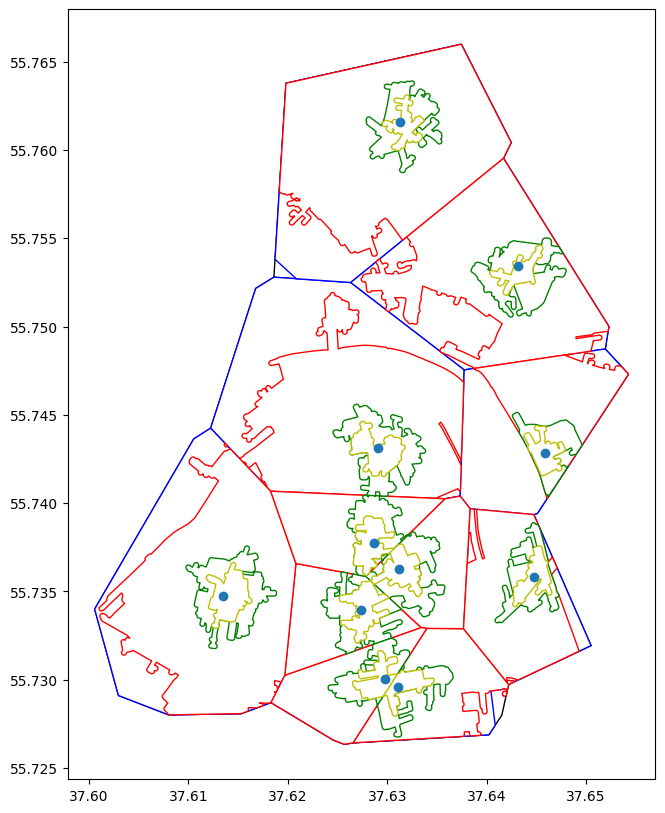

In [27]:
delta = 0.02
mask = (37.629270 - delta < df_voronoi['x']) & (df_voronoi['x'] < 37.629270 + delta) \
    & (55.743855 - delta < df_voronoi['y']) & (df_voronoi['y'] < 55.743855 + delta) 

voronoi = gpd.GeoDataFrame(df_voronoi[mask].copy(), geometry=df_voronoi[mask]['voronoi'], crs=4326)
voronoi_iso_3 = gpd.GeoDataFrame(df_voronoi[mask].copy(), geometry=df_voronoi[mask]['voronoi_iso_3'], crs=4326)
voronoi_iso_5 = gpd.GeoDataFrame(df_voronoi[mask].copy(), geometry=df_voronoi[mask]['voronoi_iso_5'], crs=4326)
voronoi_iso_10 = gpd.GeoDataFrame(df_voronoi[mask].copy(), geometry=df_voronoi[mask]['voronoi_iso_10'], crs=4326)
voronoi_iso_15 = gpd.GeoDataFrame(df_voronoi[mask].copy(), geometry=df_voronoi[mask]['voronoi_iso_15'], crs=4326)
voronoi_iso_30 = gpd.GeoDataFrame(df_voronoi[mask].copy(), geometry=df_voronoi[mask]['voronoi_iso_30'], crs=4326)
point = gpd.GeoDataFrame(df_voronoi[mask].copy(), geometry=df_voronoi[mask]['point'], crs=4326)

fig, ax = plt.subplots(1, 1, figsize = (10,10))
voronoi.plot(ax=ax, edgecolor='black', color='white')
voronoi_iso_30.plot(ax=ax, edgecolor='b', color='white')
voronoi_iso_15.plot(ax=ax, edgecolor='r', color='white')
voronoi_iso_5.plot(ax=ax, edgecolor='g', color='white')
voronoi_iso_3.plot(ax=ax, edgecolor='y', color='white')
point.plot(ax=ax)

In [28]:
clms = [
    'sales_per_month', 
    'people_iso_3', 'people_iso_5', 'people_iso_10', 
    'people_iso_15', 'people_iso_30', 
    'people_voronoi_iso_3', 'people_voronoi_iso_5', 'people_voronoi_iso_10', 
    'people_voronoi_iso_15', 'people_voronoi_iso_30',
]
df_voronoi.query('region == "Москва"')[clms].corr()['sales_per_month']

sales_per_month          1.000000
people_iso_3             0.055975
people_iso_5             0.098805
people_iso_10            0.065927
people_iso_15            0.036249
people_iso_30            0.018409
people_voronoi_iso_3     0.090049
people_voronoi_iso_5     0.242848
people_voronoi_iso_10    0.349994
people_voronoi_iso_15    0.309965
people_voronoi_iso_30    0.101265
Name: sales_per_month, dtype: float64

In [29]:
df_voronoi[clms].corr()['sales_per_month']

sales_per_month          1.000000
people_iso_3             0.075708
people_iso_5             0.116139
people_iso_10            0.113531
people_iso_15            0.081762
people_iso_30            0.047567
people_voronoi_iso_3     0.094324
people_voronoi_iso_5     0.182815
people_voronoi_iso_10    0.293510
people_voronoi_iso_15    0.298658
people_voronoi_iso_30    0.214741
Name: sales_per_month, dtype: float64

In [30]:
clms = [
    'sales_per_month','area_iso_3', 'area_iso_5', 'area_iso_10',
       'area_iso_15', 'area_iso_30', 'area_voronoi_iso_3',
       'area_voronoi_iso_5', 'area_voronoi_iso_10', 'area_voronoi_iso_15',
       'area_voronoi_iso_30',
]

df_voronoi[clms].corr()['sales_per_month']

sales_per_month        1.000000
area_iso_3             0.030499
area_iso_5             0.068574
area_iso_10            0.083912
area_iso_15            0.078658
area_iso_30            0.056508
area_voronoi_iso_3     0.039667
area_voronoi_iso_5     0.117419
area_voronoi_iso_10    0.185044
area_voronoi_iso_15    0.155453
area_voronoi_iso_30    0.092862
Name: sales_per_month, dtype: float64

In [31]:
clms = [
    'sales_per_month','ratio_iso_3','ratio_iso_5','ratio_iso_10','ratio_iso_15','ratio_iso_30'
]
df_voronoi[clms].corr()['sales_per_month']

sales_per_month    1.000000
ratio_iso_3        0.106041
ratio_iso_5        0.125178
ratio_iso_10       0.097865
ratio_iso_15       0.065206
ratio_iso_30       0.015572
Name: sales_per_month, dtype: float64